In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the dataset
# Column names from adult.names
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country",
    "income"
]

# Loading the training data
train = pd.read_csv("/content/adult.data", header=None, names=columns, na_values=" ?", skipinitialspace=True)

# Loading the test data (UCI test file has a header row and labels end with a dot)
test = pd.read_csv("/content/adult.test", header=0, names=columns, na_values=" ?", skipinitialspace=True)

# Removng the period at the end of labels if present
test["income"] = test["income"].str.replace(".", "", regex=False)

# Combining the datasets
df = pd.concat([train, test], ignore_index=True)

print("\n Dataset Loaded Successfully")
print(df.head())

# Basic dataset info
print("\n Dataset Info")
print(df.info())

print("\n Summary Statistics (Numerical)")
print(df.describe())


 Dataset Loaded Successfully
   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  
0          2174             0              40  United-States  <=50K  
1           

In [2]:
## Missing values
print("\nMissing Values per Column")
print(df.isnull().sum())


Missing Values per Column
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64



Income Class Distribution
income
<=50K    37155
>50K     11687
Name: count, dtype: int64


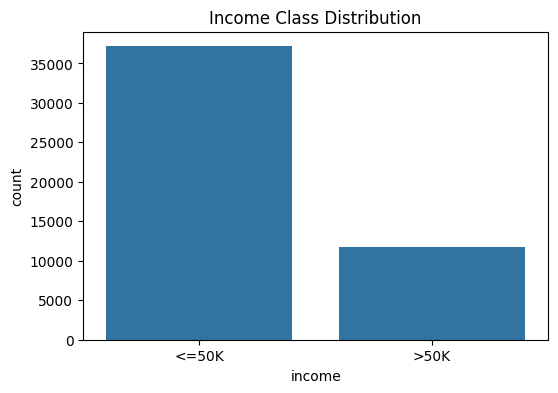

In [3]:
## Class distribution
print("\nIncome Class Distribution")
print(df["income"].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="income")
plt.title("Income Class Distribution")
plt.show()

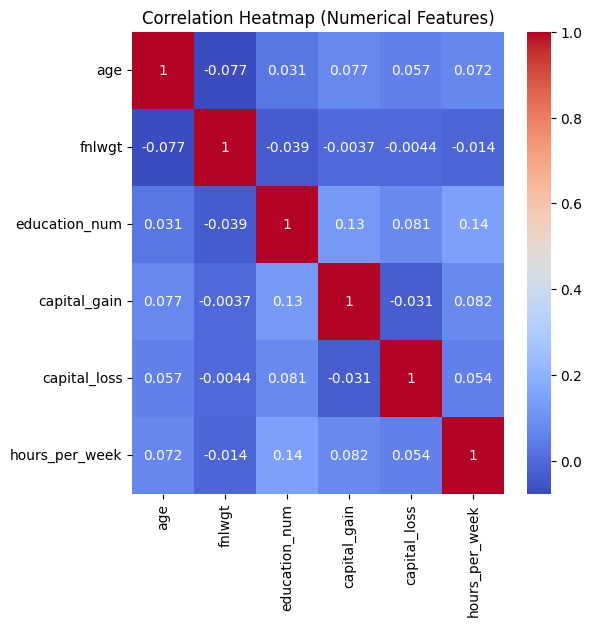

In [4]:
## Correlation heatmap
numeric_cols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
plt.figure(figsize=(6,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## CLEANING MISSING VALUES
df = df.dropna()

## ENCODING THE TARGET
df["income"] = df["income"].map({"<=50K": 0, ">50K": 1})

# SPLIT X/Y
X = df.drop("income", axis=1)
y = df["income"].astype("float32")

## ONE-HOT ENCODER FOR CATEGORICALS
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

## SCALING THE NUMERIC FEATURES
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

X_encoded = X_encoded.astype("float32")

## TRAIN / VAL / TEST SPLIT
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

## CONVERTING TO THE NUMPY FLOAT32
X_train_np = X_train.to_numpy().astype("float32")
X_val_np   = X_val.to_numpy().astype("float32")
X_test_np  = X_test.to_numpy().astype("float32")

y_train_np = y_train.to_numpy().astype("float32")
y_val_np   = y_val.to_numpy().astype("float32")
y_test_np  = y_test.to_numpy().astype("float32")


In [6]:
## CLASS WEIGHTS FOR HANDLING CLASS IMBALANCE
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_np),
    y=y_train_np
)
class_weights = {0: class_weights_arr[0], 1: class_weights_arr[1]}
print("\nClass weights:", class_weights)



Class weights: {0: np.float64(0.6572906252403291), 1: np.float64(2.089414497005256)}


In [7]:
# BUILD MLP MODEL
input_dim = X_train_np.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
## TRAINING THE MODEL
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7209 - loss: 0.5116 - val_accuracy: 0.8004 - val_loss: 0.3897
Epoch 2/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7997 - loss: 0.3906 - val_accuracy: 0.8084 - val_loss: 0.3756
Epoch 3/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7979 - loss: 0.3861 - val_accuracy: 0.8152 - val_loss: 0.3638
Epoch 4/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8074 - loss: 0.3760 - val_accuracy: 0.8066 - val_loss: 0.3765
Epoch 5/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8088 - loss: 0.3667 - val_accuracy: 0.8103 - val_loss: 0.3776
Epoch 6/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8101 - loss: 0.3763 - val_accuracy: 0.8180 - val_loss: 0.3650
Epoch 7/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8155 - loss: 0.3659 - val_accuracy: 0.8122 - val_loss: 0.3757
Epoch 8/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8118 - loss: 0.3687 - val_accuracy: 0.

In [9]:
# EVALUATING THE MODEL
val_loss, val_acc = model.evaluate(X_val_np, y_val_np, verbose=0)
test_loss, test_acc = model.evaluate(X_test_np, y_test_np, verbose=0)

print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# CLASSIFICATION REPORT
y_pred_prob = model.predict(X_test_np)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test_np, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, y_pred))



Validation Accuracy: 0.8152
Test Accuracy: 0.8126
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87      5574
         1.0       0.57      0.83      0.68      1753

    accuracy                           0.81      7327
   macro avg       0.76      0.82      0.77      7327
weighted avg       0.85      0.81      0.82      7327


Confusion Matrix:
[[4492 1082]
 [ 291 1462]]


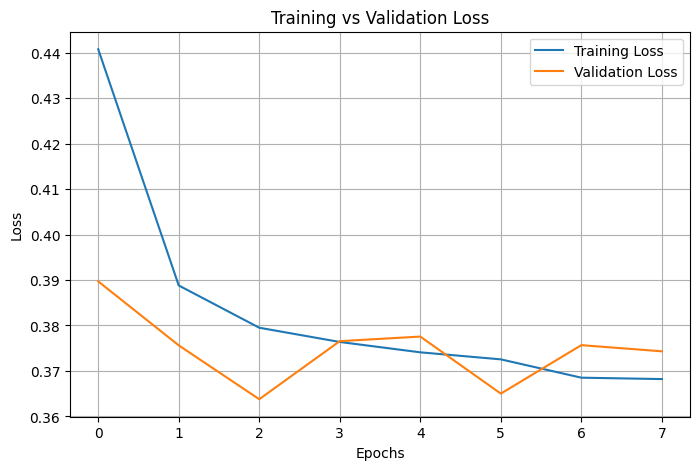

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import numpy as np

# Plotting Training/Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


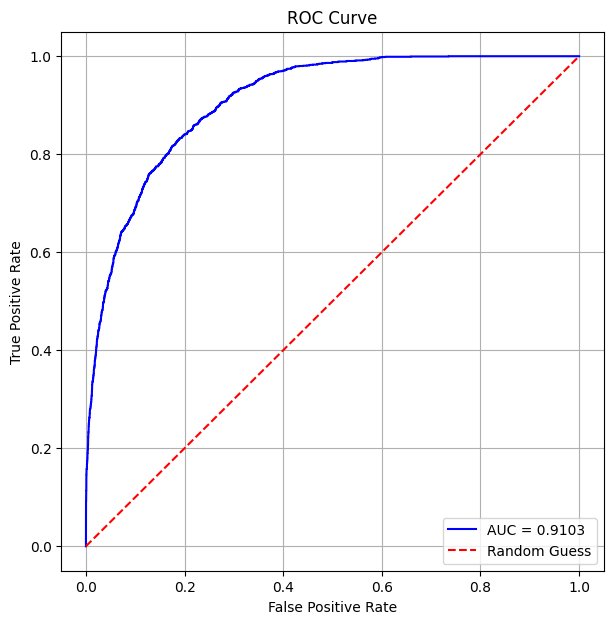

ROC AUC Score: 0.9103


In [11]:
## ROC Curve + AUC
y_pred_prob = model.predict(X_test_np).ravel()

fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Building the Stronger MLP (Model B)

input_dim = X_train_np.shape[1]

modelB = keras.Sequential([
    layers.Input(shape=(input_dim,)),

    layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1, activation="sigmoid")
])

modelB.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # lower LR for stability
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

modelB.summary()

# Training the Model B
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

historyB = modelB.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=80,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating the Model B
val_loss_B, val_acc_B = modelB.evaluate(X_val_np, y_val_np, verbose=0)
test_loss_B, test_acc_B = modelB.evaluate(X_test_np, y_test_np, verbose=0)

print(f"\nModel B Validation Accuracy: {val_acc_B:.4f}")
print(f"Model B Test Accuracy: {test_acc_B:.4f}")

# Predictions using Model B
y_pred_prob_B = modelB.predict(X_test_np).ravel()
y_pred_B = (y_pred_prob_B > 0.5).astype(int)

print("\nClassification Report (Model B):")
print(classification_report(y_test_np, y_pred_B))

print("\nConfusion Matrix (Model B):")
print(confusion_matrix(y_test_np, y_pred_B))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,865 (269.00 KB)

 Trainable params: 67,969 (265.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/80
535/535 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7195 - loss: 0.8849 - val_accuracy: 0.8193 - val_loss: 0.6754
Epoch 2/80
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7942 - loss: 0.6995 - val_accuracy: 0.8050 - val_loss: 0.6308
Epoch 3/80
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7946 - loss: 0.6383 - val_accuracy: 0.8208 - val_loss: 0.5576
Epoch 4/80
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8023 - loss: 0.5781 - val_accuracy: 0.8174 - val_loss: 0.5234
Epoch 5/80
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8071 - loss: 0.5370 - val_accuracy: 0.8069 - val_loss: 0.5017
Epoch 6/80
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8032 - loss: 0.5009 - val_accuracy: 0.8039 - val_loss: 0.4704
Epoch 7/80
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8000 - loss: 0.4788 - val_accuracy: 0.8132 - val_loss: 0.4506
Epoch 8/80
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8067 - loss: 0.4488 - val_accuracy: 

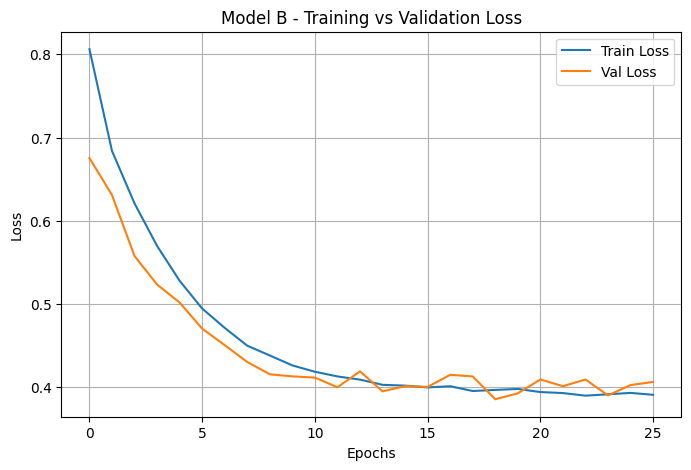

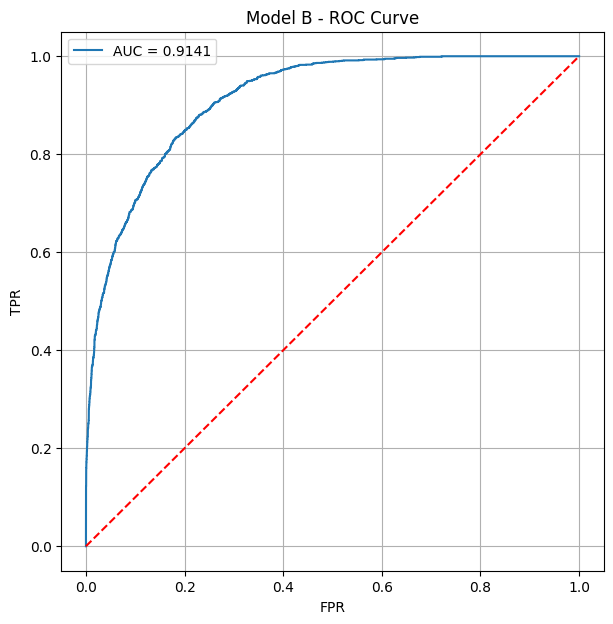

Model B ROC AUC: 0.9141


In [ ]:
# Plotting the Loss Learning Curves
plt.figure(figsize=(8,5))
plt.plot(historyB.history['loss'], label='Train Loss')
plt.plot(historyB.history['val_loss'], label='Val Loss')
plt.title("Model B - Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve + AUC
fpr_B, tpr_B, thresholds_B = roc_curve(y_test_np, y_pred_prob_B)
auc_B = auc(fpr_B, tpr_B)

plt.figure(figsize=(7,7))
plt.plot(fpr_B, tpr_B, label=f"AUC = {auc_B:.4f}")
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Model B - ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Model B ROC AUC: {auc_B:.4f}")

